In [1]:
import string
import tarfile

import numpy as np
import scipy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# Path to the tar file and the target file inside it
tar_path = 'handwritingBCIData.tar'
target_mat_path = './handwritingBCIData/Datasets/t5.2019.05.08/singleLetters.mat'

# Open the tar file
with tarfile.open(tar_path, 'r') as tar:
    # Get the file object
    mat_member = tar.getmember(target_mat_path)
    mat_file = tar.extractfile(mat_member)
    
    # Load the .mat file
    if mat_file is not None:
        data = scipy.io.loadmat(mat_file)

In [3]:
n_trials = 27
n_steps = 201 # each step is 10ms, so 201 * 10ms * 0.001ms/s ~= 2 seconds per trial
n_channels = 192

In [4]:
letterKeyFmt = "neuralActivityCube_{}"

In [5]:
# Display the # of spikes detected in the 10th electrode while writing "d".
data[letterKeyFmt.format("d")][0,:,10]

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 2, 0, 1, 1, 2, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1], dtype=uint8)

In [6]:
# Note: Flatten the first two dimensions (n_trials, n_steps) to treat each time window as a single sample.
# The neural activity at any given point will have # of dimensions = n_channels. We then use PCA to reduce
# this highly dimensional data to three dimensions. These three dimensions capture the most variance
# in the n_channels-dimensional data and thus can be thought of as a "good" representation of the neural
# activty at any given point in time (we can figure out what % of the total variance these three dimensions
# account for by summing the eigenvalues for the three PCs and dividing them by the sum of eigenvalues for all PCs).
reduced = PCA(n_components=3).fit_transform(data[letterKeyFmt.format("d")].reshape(-1, n_channels))

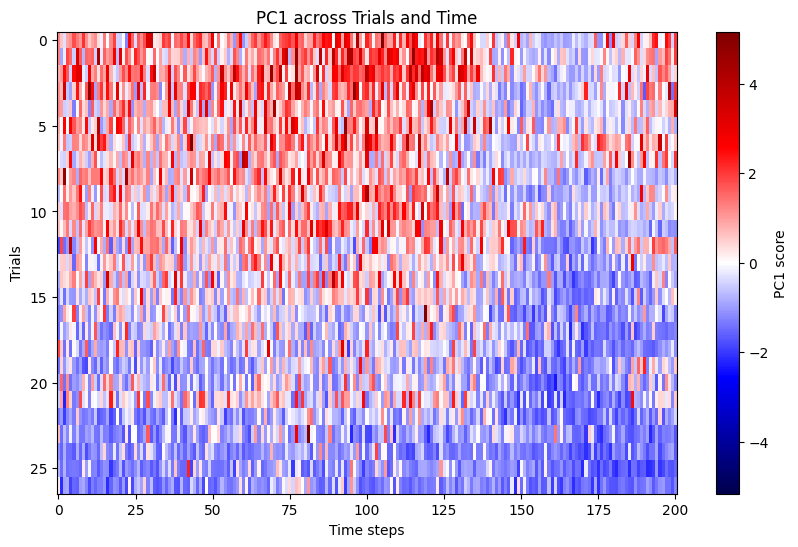

In [7]:
reduced = reduced.reshape(27, 201, 3)
pc1 = reduced[:, :, 0]

# Plot as a heatmap
plt.figure(figsize=(10, 6))
plt.imshow(pc1, aspect='auto', cmap='seismic', interpolation='nearest')
plt.colorbar(label='PC1 score')
plt.xlabel('Time steps')
plt.ylabel('Trials')
plt.title('PC1 across Trials and Time')

# Improve color mapping: make zero = white
plt.clim(-np.max(np.abs(pc1)), np.max(np.abs(pc1)))  # symmetric color limits

plt.show()

In [8]:
CHARS = list(string.ascii_lowercase) + ['greaterThan','comma','apostrophe','tilde','questionMark']
letterToIdx = {char: idx for idx, char in enumerate(CHARS)}

def apply_blockwise_zscore_and_flatten(data):
    trialsDataForEachLetter = []
    letterToIdx = dict()
    for idx, char in enumerate(CHARS):
        letterKeyFmt = "neuralActivityCube_{}"
        letterData = data[letterKeyFmt.format(char)].copy()
    
        # Three trials correspond to one recording "block". We compute a blockwise z-score for each
        # threshold crossing count to normalize drift across blocks. Since base firing rates or
        # variance can drift over time for the same neurons.
        # Q: Why three trials per block? `meansPerBlock` pre-computes means for each of the 9 blocks,
        # but couldn't we also treat each trial, or >3 trials, as a block?
        # A: Looks like each block had 3 trials for each letter. i.e. write a 3 times, then b 3 times, etc.
        trialIdx = 0
        for blockIdx in range(9):
            # (trials,steps,means)
            # each element in means represents mean threshold crossing count
            # for a particular electrode across time
            # we'll then subtract this mean from the crossing counts across all time steps
            # (with the help of broadcasting along the 2nd dimension)
            means = np.zeros((3,1,n_channels), dtype=np.float64)
            means[:,0,:] = data["meansPerBlock"][blockIdx,:]
    
            # sanity check that mean is same for the three trials
            assert np.array_equal(means[0,0,:], means[1,0,:])
            assert np.array_equal(means[0,0,:], means[2,0,:])
    
            std_devs = data["stdAcrossAllData"][np.newaxis,:]
            assert std_devs.shape == (1, 1, n_channels)
            assert std_devs.dtype == np.float64
    
            # block == 3 trials
            # (trials,steps, channels)
            letterData[trialIdx:trialIdx+3,:,:] = letterData[trialIdx:trialIdx+3,:,:] - means
            letterData[trialIdx:trialIdx+3,:,:] = letterData[trialIdx:trialIdx+3,:,:] / std_devs;
            trialIdx += 3
        trialsDataForEachLetter.append(letterData)
        letterToIdx[char] = idx
    combinedTrials = np.concatenate(trialsDataForEachLetter, axis=0)
    return combinedTrials

combinedTrials = apply_blockwise_zscore_and_flatten(data)

In [9]:
assert combinedTrials.shape == (len(CHARS) * n_trials, n_steps, n_channels)
combinedTrials.shape, letterToIdx

((837, 201, 192),
 {'a': 0,
  'b': 1,
  'c': 2,
  'd': 3,
  'e': 4,
  'f': 5,
  'g': 6,
  'h': 7,
  'i': 8,
  'j': 9,
  'k': 10,
  'l': 11,
  'm': 12,
  'n': 13,
  'o': 14,
  'p': 15,
  'q': 16,
  'r': 17,
  's': 18,
  't': 19,
  'u': 20,
  'v': 21,
  'w': 22,
  'x': 23,
  'y': 24,
  'z': 25,
  'greaterThan': 26,
  'comma': 27,
  'apostrophe': 28,
  'tilde': 29,
  'questionMark': 30})

In [10]:
# Each row is a 192D vector representing the brain state for a particular letter, trial, and time step.
combinedPCAReduced = PCA(n_components=3).fit_transform(combinedTrials.reshape(-1, n_channels))

In [11]:
# (letters, trials, steps, channels)
a = np.random.rand(*(2,3,4,5))
a_ = a.reshape(-1, 5)
assert a_.shape == (2*3*4,5)

# Checking my understanding of reshaping arrays...
# * the first 12 rows represent the flattened (trials, steps, channels) for the first letter.
# * the second 12 rows represent the data for the second letter.
assert np.array_equal(a[1], a_[12:,:].reshape(3,4,5))

In [12]:
combinedPCAReduced.shape

(168237, 3)

In [13]:
# Reshape to (letters, trials, steps, PCs).
combinedPCAReduced = combinedPCAReduced.reshape(len(CHARS), n_trials, n_steps, 3)

In [14]:
combinedPCAReduced.shape

(31, 27, 201, 3)

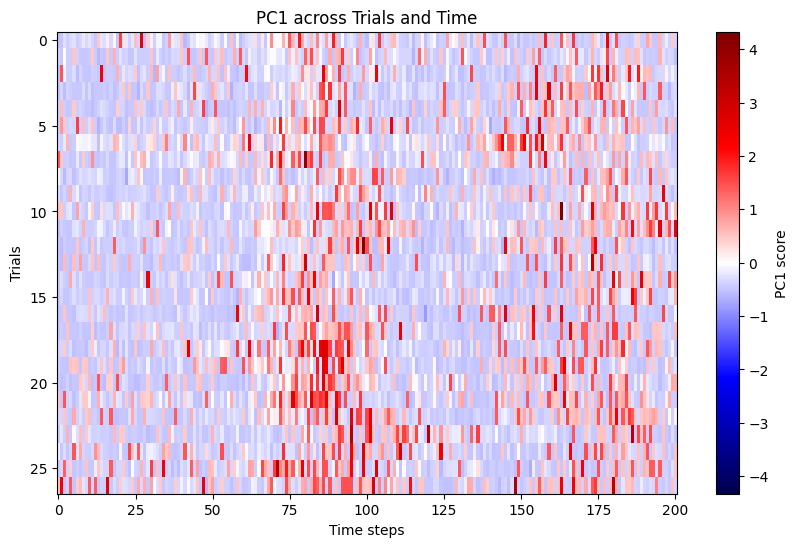

In [15]:
pc1_for_a = combinedPCAReduced[letterToIdx['d'],:,:,0]

# Plot as a heatmap
plt.figure(figsize=(10, 6))
plt.imshow(pc1_for_a, aspect='auto', cmap='seismic', interpolation='nearest')
plt.colorbar(label='PC1 score')
plt.xlabel('Time steps')
plt.ylabel('Trials')
plt.title('PC1 across Trials and Time')

# Improve color mapping: make zero = white
plt.clim(-np.max(np.abs(pc1_for_a)), np.max(np.abs(pc1_for_a)))  # symmetric color limits

plt.show()

In [16]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import LinearSegmentedColormap

matlab_style_cmap = LinearSegmentedColormap.from_list(
    "matlab_diverging",
    # ["blueviolet", "white", "darkorange"],
    ["indigo", "white", "orangered"]
)

def plot_pcs_grid(combinedPCAReduced, letterToIdx, letters, n_pcs=3):
    """
    Plot a grid of PC score heatmaps across time.
    Rows = letters, Columns = PCs.

    Args:
        combinedPCAReduced: np.ndarray of shape (n_letters, n_trials, n_time_steps, n_pcs)
        letterToIdx: dict mapping letter to index in combinedPCAReduced
        letters: list of letters to plot (e.g., ['d', 'e', 'm'])
        n_pcs: number of PCs to show per letter (default 3)
    """
    n_rows = len(letters)
    n_cols = n_pcs

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), constrained_layout=True)
    axes = np.atleast_2d(axes)

    for row_idx, letter in enumerate(letters):
        letter_idx = letterToIdx[letter]
        for col_idx in range(n_pcs):
            ax = axes[row_idx, col_idx]
            pc_scores = combinedPCAReduced[letter_idx, :, :, col_idx]

            im = ax.imshow(pc_scores, aspect='auto', cmap='seismic', interpolation='nearest')

            # add vertical line when "go" signal was given to start writing
            ax.axvline(x=50, color='black', linestyle='-', linewidth=1)
            ax.set_title(f"{letter.upper()} - PC{col_idx + 1}")
            ax.set_xlabel("Time steps")
            ax.set_ylabel("Trials")

            clim = np.max(np.abs(pc_scores))
            im.set_clim(-clim, clim)
            plt.colorbar(im, ax=ax, shrink=0.8)

    plt.suptitle("PCs Across Trials and Time", fontsize=16)
    plt.show()


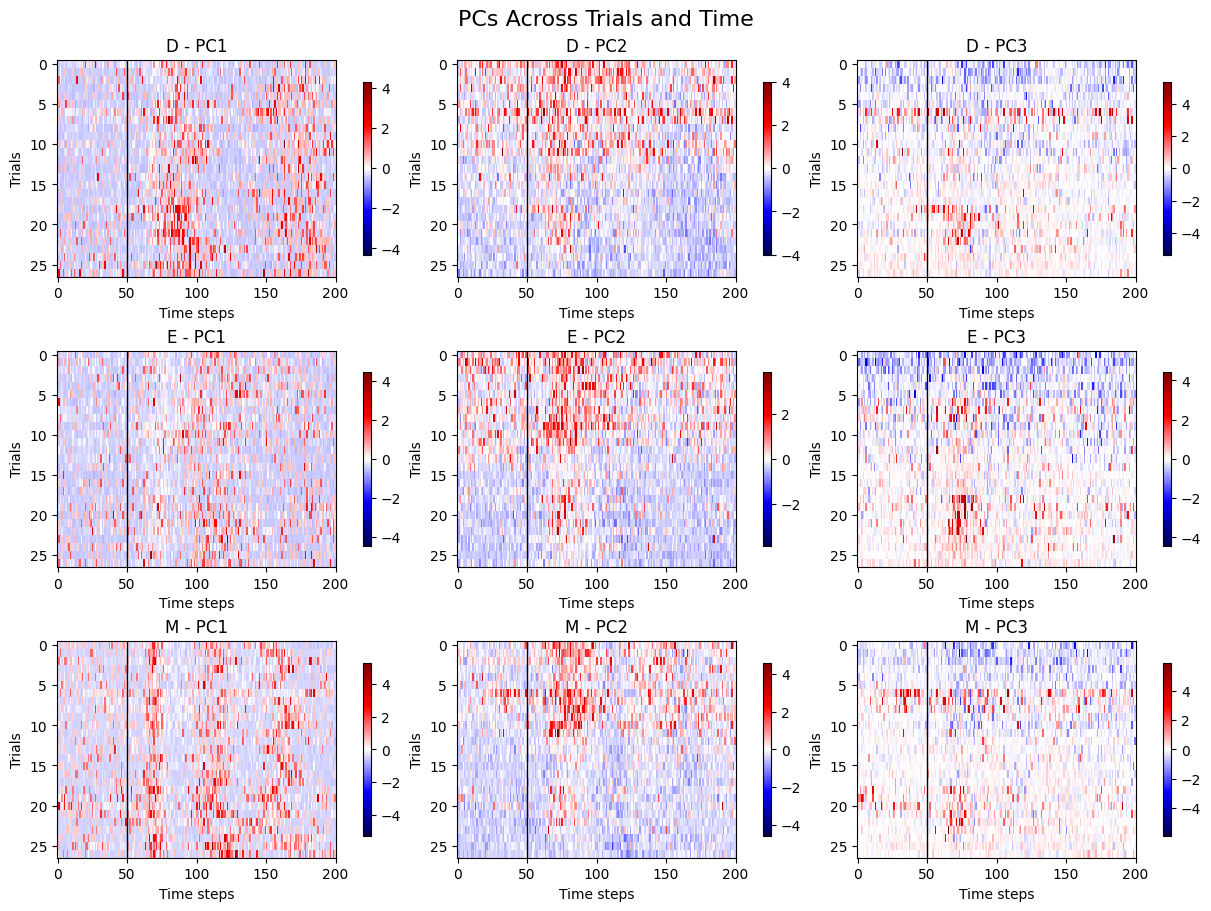

In [17]:
# This is with blockwise z-scoring but with PCs that were fit to single-trial data.
# Going to try to fit PCs to trial-averaged data.
plot_pcs_grid(combinedPCAReduced, letterToIdx, letters=['d', 'e', 'm'])

In [18]:
def apply_blockwise_zscore_and_trial_average_and_flatten(data):
    # normalized, averaged, and smoothed activity for each letter
    # (n_steps, n_channels) for each letter
    letterActivity = []
    letterToIdx = dict()
    for idx, char in enumerate(string.ascii_lowercase):
        letterKeyFmt = "neuralActivityCube_{}"
        letterData = data[letterKeyFmt.format(char)].copy()
    
        # Three trials correspond to one recording "block". We compute a blockwise z-score for each
        # threshold crossing count to normalize drift across blocks. Since base firing rates or
        # variance can drift over time for the same neurons.
        # Q: Why three trials per block? `meansPerBlock` pre-computes means for each of the 9 blocks,
        # but couldn't we also treat each trial, or >3 trials, as a block?
        # A: Looks like each block had 3 trials for each letter. i.e. write a 3 times, then b 3 times, etc.
        trialIdx = 0
        for blockIdx in range(9):
            # (trials,steps,means)
            # each element in means represents mean threshold crossing count
            # for a particular electrode across time
            # we'll then subtract this mean from the crossing counts across all time steps
            # (with the help of broadcasting along the 2nd dimension)
            means = np.zeros((3,1,n_channels), dtype=np.float64)
            means[:,0,:] = data["meansPerBlock"][blockIdx,:]
    
            # sanity check that mean is same for the three trials
            assert np.array_equal(means[0,0,:], means[1,0,:])
            assert np.array_equal(means[0,0,:], means[2,0,:])
    
            std_devs = data["stdAcrossAllData"][np.newaxis,:]
            assert std_devs.shape == (1, 1, n_channels)
            assert std_devs.dtype == np.float64
    
            # block == 3 trials
            # (trials,steps, channels)
            letterData[trialIdx:trialIdx+3,:,:] = letterData[trialIdx:trialIdx+3,:,:] - means
            letterData[trialIdx:trialIdx+3,:,:] = letterData[trialIdx:trialIdx+3,:,:] / std_devs;
            trialIdx += 3

        # compute average activity across trials
        letterAvgActivity = np.mean(letterData, axis=0)
        letterActivity.append(letterAvgActivity)
        letterToIdx[char] = idx
    combinedTrials = np.concatenate(letterActivity, axis=0)
    return combinedTrials

combinedTrialsV2 = apply_blockwise_zscore_and_trial_average_and_flatten(data)

In [19]:
# fit the PCA on trial-averaged data
pca_v2 = PCA(n_components=3).fit(combinedTrialsV2.reshape(-1, n_channels))

# then project trial data onto PCs
combinedPCAReducedV2 = pca_v2.transform(combinedTrials.reshape(-1, n_channels))
combinedPCAReducedV2 = combinedPCAReducedV2.reshape(len(CHARS), n_trials, n_steps, 3)

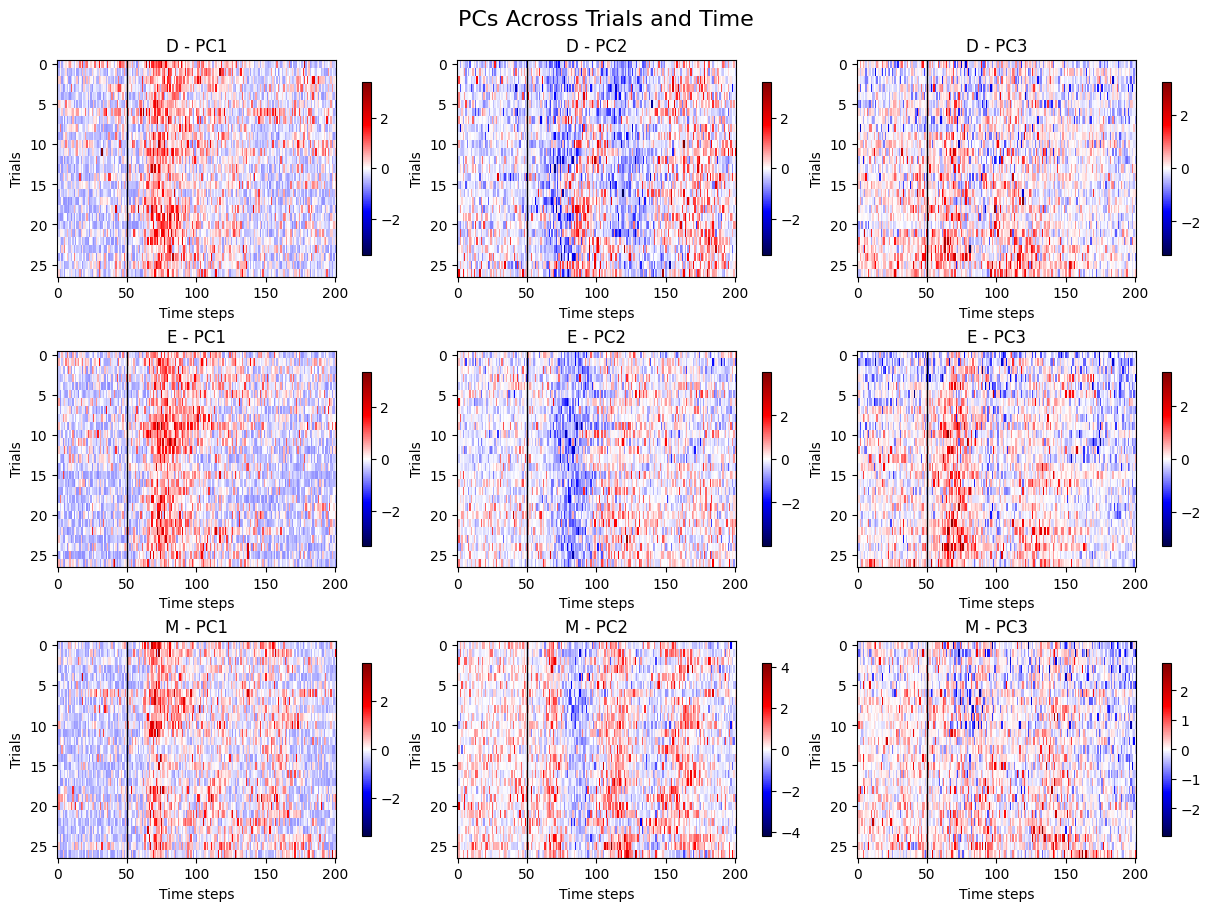

In [20]:
# This is with blockwise z-scoring but with PCs that were fit to single-trial data.
# Going to try to fit PCs to trial-averaged data.
plot_pcs_grid(combinedPCAReducedV2, letterToIdx, letters=['d', 'e', 'm'])

In [21]:
from scipy.stats import norm
from scipy.signal import lfilter

def gauss_smooth_fast(time_series, width):
    """
    Faithful Python reimplementation of gaussSmooth_fast from Willett et al.
    Applies Gaussian smoothing with edge correction, mimicking MATLAB's filter-based approach.

    Args:
        time_series (ndarray): shape (time, channels)
        width (float): std dev (sigma) of Gaussian kernel

    Returns:
        ndarray: smoothed time series of same shape
    """
    if width == 0:
        return time_series.copy()

    time_steps, channels = time_series.shape

    # Build Gaussian kernel (same as normpdf in MATLAB)
    wing_size = int(np.ceil(width * 5))
    x = np.arange(-wing_size, wing_size + 1)
    g_kernel = norm.pdf(x, 0, width)
    g_kernel /= np.sum(g_kernel)  # Normalize kernel sum to 1

    # Causal-style filtering (zero-padded at the end)
    padded = np.vstack([time_series, np.zeros((len(g_kernel) - 1, channels))])  # pad below
    y = lfilter(g_kernel, 1, padded, axis=0)  # forward filter only

    # Edge correction (start)
    norm_factor = np.cumsum(g_kernel)
    for i in range(len(g_kernel) - 1):
        y[i, :] /= norm_factor[i]

    # Edge correction (end)
    for i in range(len(g_kernel) - 1):
        y[-(i + 1), :] /= norm_factor[i]

    # Trim padded rows to recover original size
    trim = (len(g_kernel) - 1) // 2
    y = y[trim: trim + time_steps, :]

    return y

In [26]:
from collections import OrderedDict

def apply_blockwise_zscore_and_trial_average_guassian_smoothing_and_flatten(data):
    # normalized and smoothed activity for each trial
    perTrialLetterActivities = OrderedDict()
    warpedPerTrialLetterActivities = OrderedDict()

    # normalized, averaged, and smoothed activity for each letter
    # (n_steps, n_channels) for each letter
    letterActivities = []
    warpedLetterActivities = []
    letterToIdx = dict()
    for idx, char in enumerate(CHARS):
        letterKeyFmt = "neuralActivityCube_{}"
        letterData = data[letterKeyFmt.format(char)].copy()
    
        # Three trials correspond to one recording "block". We compute a blockwise z-score for each
        # threshold crossing count to normalize drift across blocks. Since base firing rates or
        # variance can drift over time for the same neurons.
        # Q: Why three trials per block? `meansPerBlock` pre-computes means for each of the 9 blocks,
        # but couldn't we also treat each trial, or >3 trials, as a block?
        # A: Looks like each block had 3 trials for each letter. i.e. write a 3 times, then b 3 times, etc.
        trialIdx = 0
        for blockIdx in range(9):
            # (trials,steps,means)
            # each element in means represents mean threshold crossing count
            # for a particular electrode across time
            # we'll then subtract this mean from the crossing counts across all time steps
            # (with the help of broadcasting along the 2nd dimension)
            means = np.zeros((3,1,n_channels), dtype=np.float64)
            means[:,0,:] = data["meansPerBlock"][blockIdx,:]
    
            # sanity check that mean is same for the three trials
            assert np.array_equal(means[0,0,:], means[1,0,:])
            assert np.array_equal(means[0,0,:], means[2,0,:])
    
            std_devs = data["stdAcrossAllData"][np.newaxis,:]
            assert std_devs.shape == (1, 1, n_channels)
            assert std_devs.dtype == np.float64
    
            # block == 3 trials
            # (trials,steps, channels)
            letterData[trialIdx:trialIdx+3,:,:] = letterData[trialIdx:trialIdx+3,:,:] - means
            letterData[trialIdx:trialIdx+3,:,:] = letterData[trialIdx:trialIdx+3,:,:] / std_devs;
            trialIdx += 3

        # smooth per-trial activity
        # truncate everything before this, maybe bc "go" was at step 50?
        # not sure if they applied this to single-trial activity for PCA figures or just for fitting t-SNE
        smooth_start_ts = 60
        perTrialLetterActivity = np.zeros(shape=(n_trials, n_steps, n_channels))
        for trial in range(n_trials):
            perTrialLetterActivity[trial, :, :] = gauss_smooth_fast(letterData[trial, :, :], width=3)
        perTrialLetterActivities[char] = perTrialLetterActivity

        # this gives wonky PCA heatmaps:
        # perTrialLetterActivities[char] = scipy.ndimage.filters.gaussian_filter1d(letterData, 3.0, axis=1)

        # compute average activity across trials, truncate from step 60 on, and smooth
        # Note: why is the width larger here? Isn't trial-averaged signal more dense, less sparse, thus
        #  would it make more sense to have a narrower kernel? or maybe it just doesn't matter as much
        letterAvgActivity = gauss_smooth_fast(np.mean(letterData, axis=0)[smooth_start_ts:, :], width=5)
        letterActivities.append(letterAvgActivity)
        letterToIdx[char] = idx

        # # fit a time warping model on the smoothed activity
        # # note: doesn't seem to be able to fit on raw activity, loss doesn't improve at all
        # pw_linear_model = PiecewiseWarping(
        #     n_knots=201,
        #     smoothness_reg_scale=1.0,
        #     warp_reg_scale=0.001,
        # )

        # # note: this didn't work, just set iterations to 1 to make it go fast
        # pw_linear_model.fit(perTrialLetterActivities[char], iterations=1)

        # # align raw activity then smooth
        # warpedActivity = pw_linear_model.transform(letterData)
        # smoothedWarpedActivity = np.zeros(shape=(n_trials, n_steps, n_channels))
        # for trial in range(n_trials):
        #     smoothedWarpedActivity[trial, :, :] = gauss_smooth_fast(warpedActivity[trial, :, :], width=3)
        # warpedPerTrialLetterActivities[char] = smoothedWarpedActivity

        # # compute smoothed average warped activity across trials
        # warpedAvgActivity = gauss_smooth_fast(np.mean(warpedActivity, axis=0)[smooth_start_ts:, :], width=5)
        # warpedLetterActivities.append(warpedAvgActivity)

    combinedTrials = np.concatenate(list(perTrialLetterActivities.values()), axis=0)
    combinedTrialsAvgs = np.concatenate(letterActivities, axis=0)

    # combinedWarpedTrialsAvgs = np.concatenate(warpedLetterActivities, axis=0)
    return perTrialLetterActivities, warpedPerTrialLetterActivities, combinedTrials, combinedTrialsAvgs

trialsPerLetterV3, warpedTrialsPerLetterV3, combinedTrialsV3, combinedTrialsAvgV3 = apply_blockwise_zscore_and_trial_average_guassian_smoothing_and_flatten(data)
# combined_warped_trials = np.concatenate(list(warpedTrialsPerLetterV3.values()), axis=0)

In [28]:
combinedTrialsV3.shape

(837, 201, 192)

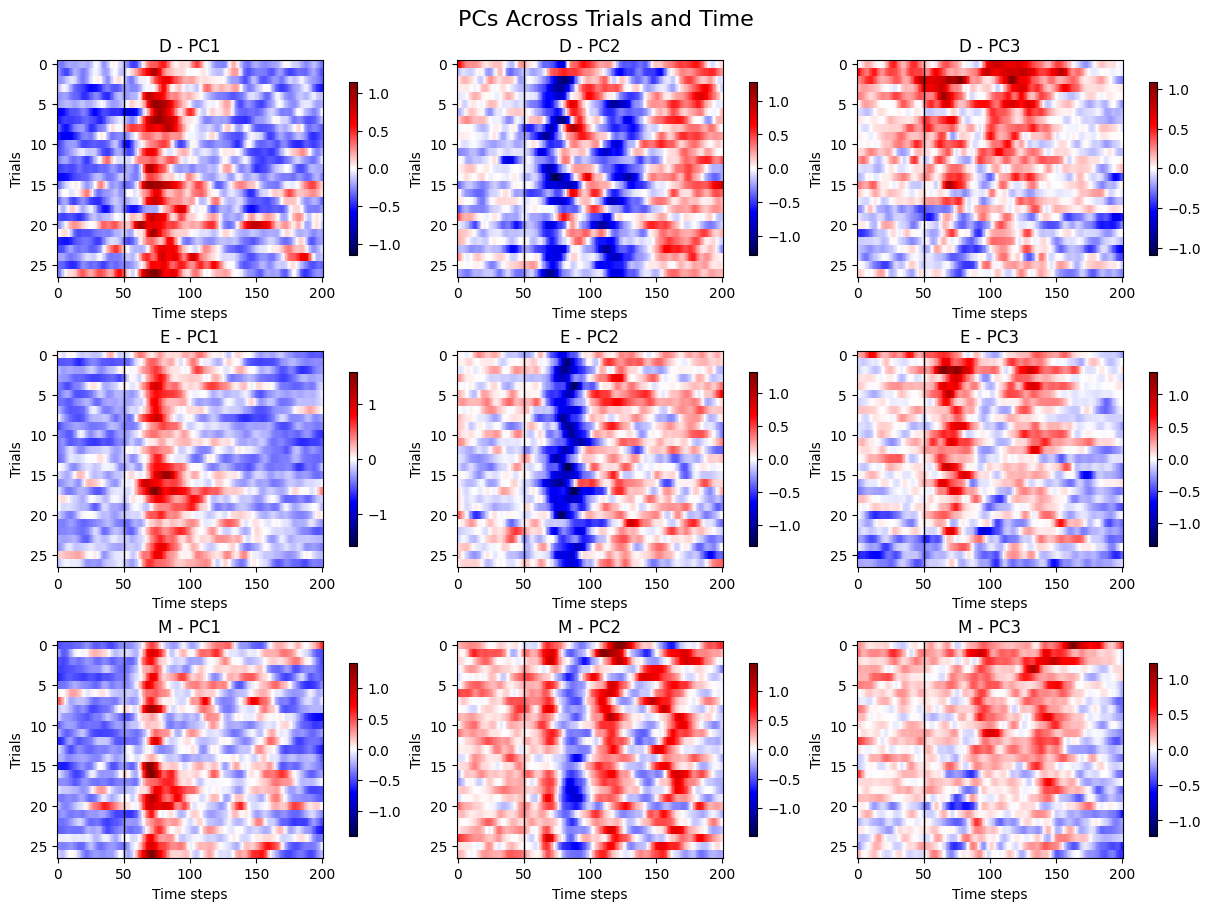

In [29]:
# fit the PCA on trial-averaged data
pca_v3 = PCA(n_components=3).fit(combinedTrialsAvgV3.reshape(-1, n_channels))

# then project trial data onto PCs
projected_v3 = pca_v3.transform(combinedTrialsV3.reshape(-1, n_channels))
projected_v3 = projected_v3.reshape(len(CHARS), n_trials, n_steps, 3)

# This is with blockwise z-scoring but with PCs that were fit to single-trial data.
# Going to try to fit PCs to trial-averaged data.
# flip to put trial 27 on top (that's what they do idk why)
plot_pcs_grid(np.flip(projected_v3, axis=1), letterToIdx, letters=['d', 'e', 'm'])

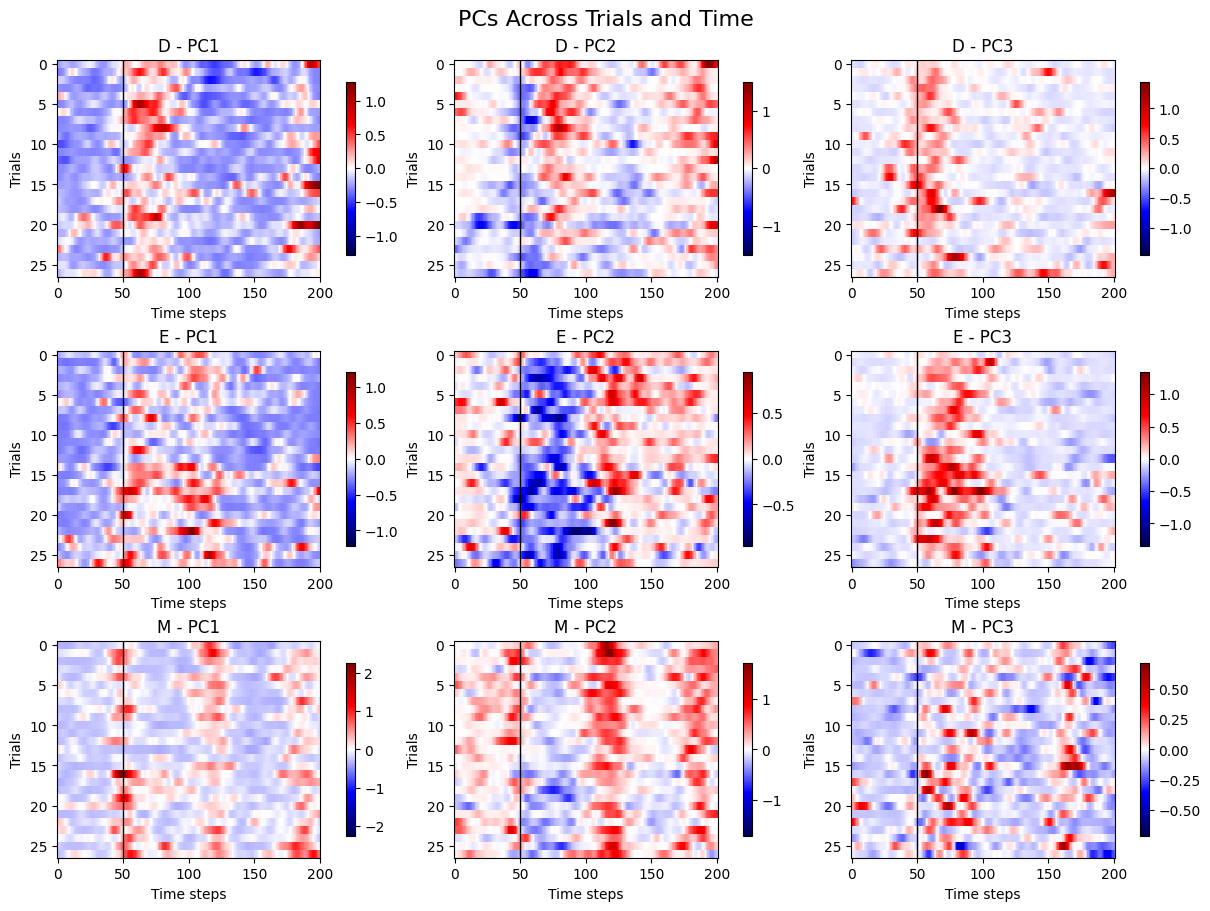

In [107]:
# fit the PCA on trial-averaged data
warped_pca_v3 = PCA(n_components=3).fit(combinedWarpedTrialsAvgV3.reshape(-1, n_channels))

# then project trial data onto PCs
warped_projected_v3 = warped_pca_v3.transform(combined_warped_trials.reshape(-1, n_channels)).reshape(len(CHARS), n_trials, n_steps, 3)

# This is with blockwise z-scoring but with PCs that were fit to single-trial data.
# Going to try to fit PCs to trial-averaged data.
# flip to put trial 27 on top (that's what they do idk why)
plot_pcs_grid(np.flip(warped_projected_v3, axis=1), letterToIdx, letters=['d', 'e', 'm'])

In [30]:
# smooth activity across time before fitting warping function; this is important
print(trialsPerLetterV3['d'].shape)
d_smoothed_activity = scipy.ndimage.filters.gaussian_filter1d(trialsPerLetterV3['d'][:20], 3.0, axis=1)
print(d_smoothed_activity.shape)

(27, 201, 192)
(20, 201, 192)


/var/folders/n_/8p1gdnb570j4m06ltsyf5d1w0000gn/T/ipykernel_77124/3496259651.py:3: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  d_smoothed_activity = scipy.ndimage.filters.gaussian_filter1d(trialsPerLetterV3['d'][:20], 3.0, axis=1)


In [70]:
# try to find hp's for one letter
# task 1: compare optimization curves for shift-only vs. linear vs. few knot piecewise linear model
# task 2: put data into SpikeData format
# task 3: visualize raster plots of raw data vs aligned
from affinewarp import ShiftWarping, PiecewiseWarping, SpikeData

noop_model = ShiftWarping(
    maxlag=0.0,
)

shift_model = ShiftWarping(
    smoothness_reg_scale=0.5,
    warp_reg_scale=1e-2,
    maxlag=0.15,
)
linear_model = PiecewiseWarping(
    n_knots=0,
    smoothness_reg_scale=1.0,
    warp_reg_scale=0.001,
)
pw_linear_model = PiecewiseWarping(
    n_knots=5,
    smoothness_reg_scale=1.0,
    warp_reg_scale=0.001,
)

In [72]:
noop_model.fit(d_smoothed_activity, iterations=1)
noop_aligned_data = noop_model.transform(d_smoothed_activity)

Loss: 0.01: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00, 128.65it/s]


Type:        str
String form: quadratic
Length:      9
Docstring:  
str(object='') -> str
str(bytes_or_buffer[, encoding[, errors]]) -> str

Create a new string object from the given object. If encoding or
errors is specified, then the object must expose a data buffer
that will be decoded using the given encoding and error handler.
Otherwise, returns the result of object.__str__() (if defined)
or repr(object).
encoding defaults to sys.getdefaultencoding().
errors defaults to 'strict'.

In [64]:
shift_model.fit(d_smoothed_activity, iterations=50)
shift_aligned_data = shift_model.transform(d_smoothed_activity)

Loss: 0.01: 100%|██████████████████████████████████████████████████| 50/50 [00:00<00:00, 116.43it/s]


In [65]:
linear_model.fit(d_smoothed_activity, iterations=50)
linear_aligned_data = linear_model.transform(d_smoothed_activity)

Loss improvement: 6.75%: 100%|██████████████████████████████████████| 50/50 [00:03<00:00, 16.59it/s]


In [59]:
pw_linear_model.fit(d_smoothed_activity, iterations=50)
pw_linear_aligned_data = pw_linear_model.transform(d_smoothed_activity)

Loss improvement: 23.10%: 100%|█████████████████████████████████████| 50/50 [00:02<00:00, 16.98it/s]


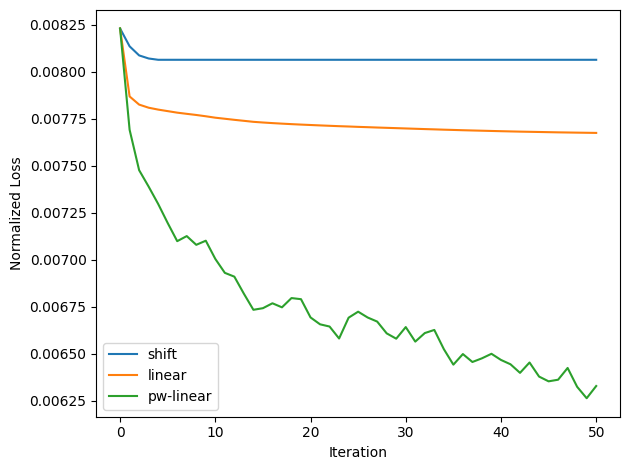

In [67]:
plt.plot(shift_model.loss_hist, label="shift")
plt.plot(linear_model.loss_hist, label="linear")
plt.plot(pw_linear_model.loss_hist, label="pw-linear")
plt.xlabel("Iteration")
plt.ylabel("Normalized Loss")
plt.legend()
plt.tight_layout()

In [ ]:
# def plot_pcs_grid(smoothed_letter_activity, n_rows=6, n_cols=5):
#     """
#     """
#     fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), constrained_layout=True)
#     axes = np.atleast_2d(axes)

#     for row_idx in range(n_rows):
#         for col_idx in range(n_cols):
#             ax = axes[row_idx, col_idx]
#             pc_scores = combinedPCAReduced[letter_idx, :, :, col_idx]

#             im = ax.imshow(pc_scores, aspect='auto', cmap='seismic', interpolation='nearest')

#             # add vertical line when "go" signal was given to start writing
#             ax.axvline(x=50, color='black', linestyle='-', linewidth=1)
#             ax.set_title(f"{letter.upper()} - PC{col_idx + 1}")
#             ax.set_xlabel("Time steps")
#             ax.set_ylabel("Trials")

#             clim = np.max(np.abs(pc_scores))
#             im.set_clim(-clim, clim)
#             plt.colorbar(im, ax=ax, shrink=0.8)

#     plt.suptitle("PCs Across Trials and Time", fontsize=16)
#     plt.show()


In [35]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

from twpca import TWPCA
from twpca.regularizers import curvature


#Clears the previous character's graph
# tf.reset_default_graph()

#Number of factors used to denoise the data while time-warping (by approximating data with low-rank matrices)
n_components = 5

#Adds an L1 penalty on the second order finite difference of the warping functions.
#This encourages the warping functions to be piecewise linear.
warp_regularizer = curvature(scale=0.001, power=1)

#Adds an L2 penatly on the second order finite difference of the temporal factors.
#Encourages the temporal factors to be smooth in time.
time_regularizer = curvature(scale=1.0, power=2, axis=0)

# Smooths the binned spike counts before time-warping to denoise them (this step is key!)
# smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(dat['neuralActivityCube_'+'d'], 3.0, axis=1)

# fit time-warping model
model = TWPCA(d_smoothed_activity, 
              n_components, 
              warp_regularizer=warp_regularizer, 
              time_regularizer=time_regularizer).fit(progressbar=False)

# use the model object to align data 
estimated_aligned_data = model.transform(d_smoothed_activity)
smoothed_aligned_data = scipy.ndimage.filters.gaussian_filter1d(estimated_aligned_data, 3.0, axis=1)


2025-06-16 20:59:18.285685: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_scale_1/Assign' id:13448 op device:{requested: '', assigned: ''} def:{{{node tau_scale_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_scale_1, tau_scale_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-06-16 20:59:20.269863: W tensorflow/c/c_api.cc:305] Operation '{name:'tau_1/Adam_1/Assign' id:26313 op device:{requested: '', assigned: ''} def:{{{node tau_1/Adam_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](tau_1/Adam_1, tau_1/Adam_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future